### Shivanka Priyashan
### Index No : 190476V

#### Question 01

In [9]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

N = 100
half_n = N//2
r = 10
s = r /16
t = np.random.uniform (0 , 2*np.pi , half_n )
n = s*np.random.randn( half_n )
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circ = np.hstack(( x.reshape(half_n , 1 ) , y.reshape (half_n , 1 )))
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack(( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np.vstack ( ( X_line ,X_circ  ) )

# plt.figure(figsize=(16,16))
# for point in X:
#    plt.scatter(point[0],point[1])
#    plt.axis("equal")
# plt.show()

In [30]:
import random

def circle_from3points(pointSet,iter_num,thresh):

    max_inlier_count = 0
    for i in range(iter_num):
        #Obtain index of 3 random points
        point1, point2, point3 = random.randint(0,len(pointSet)-1), random.randint(0,len(pointSet)-1),random.randint(0,len(pointSet)-1)
        x1,x2,x3 = pointSet[point1][0], pointSet[point2][0], pointSet[point3][0]
        y1,y2,y3 = pointSet[point1][1], pointSet[point2][1], pointSet[point3][1]

        A = np.array([[(x1**2 + y1**2), x1, y1, 1], [(x2**2 + y2**2), x2, y2, 1], [(x3**2 + y3**2), x3, y3, 1]])
        M_11 = np.linalg.det(A[:,1:])
        if M_11 == 0 : continue
        M_12 = np.linalg.det(np.concatenate((A[:,0].reshape((3,1)),A[:,2:].reshape((3,2))),axis = 1))     
        M_13 = np.linalg.det(np.concatenate((A[:,:2].reshape((3,2)),A[:,3].reshape((3,1))),axis = 1))   
        M_14 = np.linalg.det(A[:,:3])
        x0 = (1/2)*(M_12/M_11)
        y0 = (-1/2)*(M_13/M_11)
        r = np.sqrt(x0**2 + y0**2 + abs(M_14/M_11))

        if r > 10 : continue
        
        inlier_count, outlier_count = 0, 0
        inlier_points, outlier_points = [],[]
        
        for j in range(len(pointSet)):
            point = pointSet[j]
            x,y = point[0], point[1]
            distance = abs(np.sqrt((x - x0)**2 + (y - y0)**2) - r) 
            if distance < thresh:
                inlier_count+=1
                inlier_points.append(point)
            else:
                outlier_count+=1
                outlier_points.append(point)

        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            attr = [x0,y0,r]
            best_fit_pts = np.array([pointSet[point1],pointSet[point2],pointSet[point3]]).T
            selected_inliers = np.array(inlier_points).T
            selected_outliers = np.array(outlier_points).T

    return max_inlier_count, attr, best_fit_pts, selected_inliers, selected_outliers

Number of iterations:  34
RANSAC Inlier count:  48


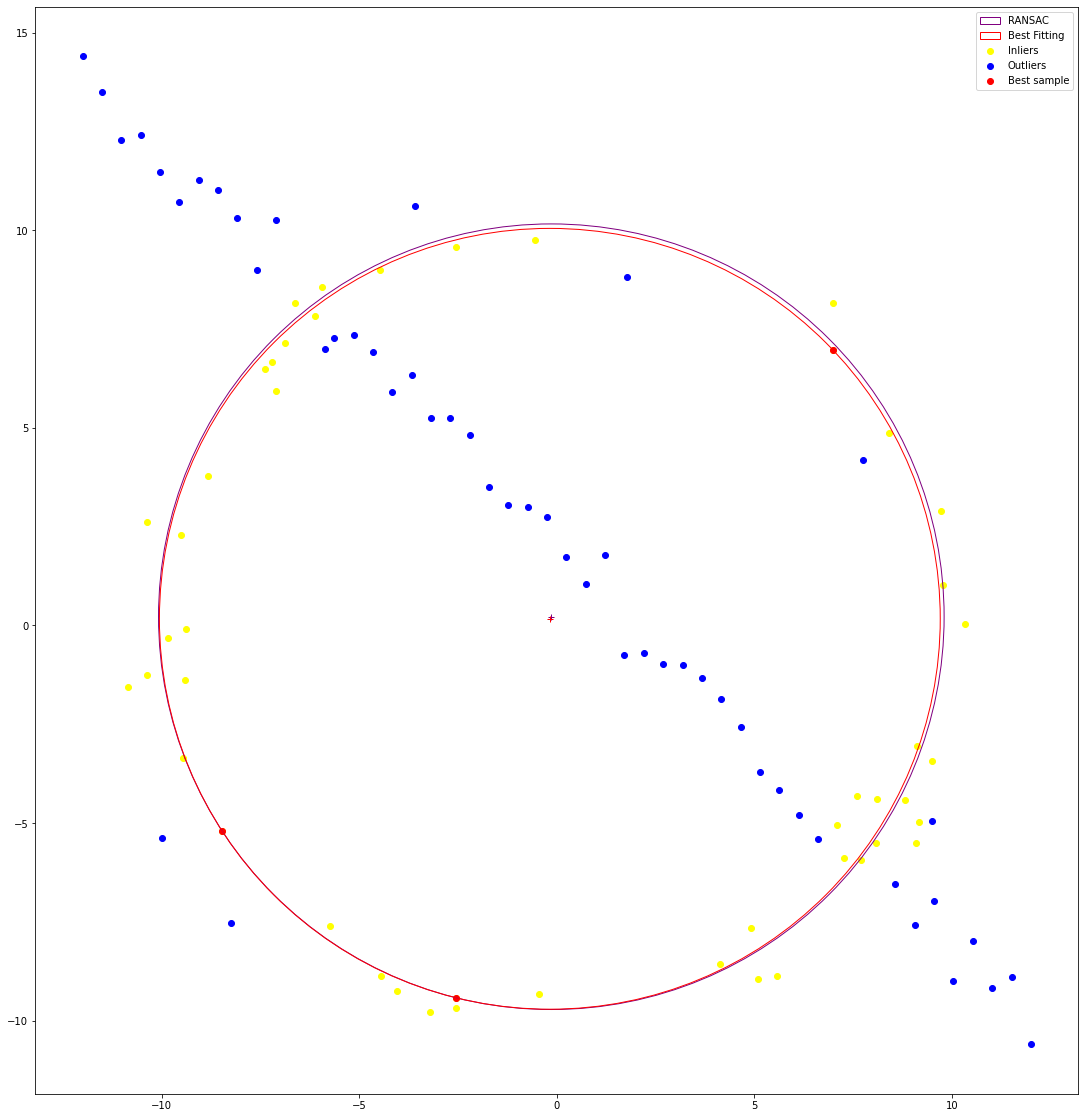

In [54]:
s = 3
t = 1                                       #threshold
e = 0.5                                     #outlier ratio
p = 0.99                                    #probability that at least one sample is free from outliers
N  = int(np.log(1-p)/ np.log(1-(1-e)**s))

fig, ax = plt.subplots(1,figsize=(20,20))

#######  RANSAC circle #########
RANSCAC_inlier_count, RANSAC_circle_attr, best_fit_pts, RANSAC_selected_inliers, RANSAC_selected_outliers = circle_from3points(X,N,t)
RANSAC_circle = plt.Circle((RANSAC_circle_attr[0],RANSAC_circle_attr[1]),RANSAC_circle_attr[2],fill=False,color='purple',label='RANSAC')
ax.add_patch(RANSAC_circle)
ax.plot(RANSAC_circle_attr[0],RANSAC_circle_attr[1],'+',color='purple')
ax.scatter(RANSAC_selected_inliers[0],RANSAC_selected_inliers[1],color='yellow',label='Inliers')
ax.scatter(RANSAC_selected_outliers[0],RANSAC_selected_outliers[1],color='blue',label='Outliers')

####### Best fitting circle ########
bestFitInlierCount, bestFitCircleAttr, bestFitPts, bestFitSI, bestFitSO = circle_from3points(RANSAC_selected_inliers.T,12000,t)
bestfit_circle = plt.Circle((bestFitCircleAttr[0],bestFitCircleAttr[1]),bestFitCircleAttr[2],fill=False,color='red',label='Best Fitting')
ax.add_patch(bestfit_circle)
ax.plot(bestFitCircleAttr[0],bestFitCircleAttr[1],'+',color='red')
ax.scatter(bestFitPts[0],bestFitPts[1],color='red', label='Best sample')

print('Number of iterations: ',N)
print('RANSAC Inlier count: ',RANSCAC_inlier_count)

ax.set_aspect('equal')
plt.legend(loc='upper right')
plt.show()

#### Question 02

##### Computing Homography

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def MouseClick(event,x,y,flag,param):
    global im_temp, pts_dst
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(im_temp, (x,y), 2, (0,0,255), 3, cv.LINE_AA)
        cv.imshow('Image',im_temp)
        if len(pts_dst) < 4:
            pts_dst = np.append(pts_dst,[(x,y)],axis=0)

def Homography(dst, src, alpha, beta):
    global im_temp, pts_dst
    dst_img = cv.imread(dst)
    dst_img_RGB = cv.cvtColor(dst_img,cv.COLOR_BGR2RGB)

    flag = cv.imread(src)
    flag_RGB = cv.cvtColor(flag,cv.COLOR_BGR2RGB)

    assert dst_img is not None
    assert flag is not None

    im_temp = dst_img.copy()

    pts_dst = np.empty((0,2))
    print(pts_dst)

    cv.namedWindow('Image',1)
    cv.imshow('Image',im_temp)
    cv.setMouseCallback("Image", MouseClick)
    cv.waitKey(0)

    bh, bw = dst_img.shape[0], dst_img.shape[1]
    fh, fw = flag.shape[0], flag.shape[1]

    pts_src = np.array([[0,0],[fw-1,0],[fw-1,fh-1],[0,fh-1]])

    hmg_matrix, status = cv.findHomography(pts_src, pts_dst)

    transformed_flag = cv.warpPerspective(flag, hmg_matrix, (bw,bh))    
    transformed_flag_RGB = cv.cvtColor(transformed_flag,cv.COLOR_BGR2RGB)

    blended_image = cv.addWeighted(dst_img,alpha,transformed_flag,beta,0.0)
    blended_image_RGB = cv.cvtColor(blended_image,cv.COLOR_BGR2RGB)

    fig, ax = plt.subplots(4,1,figsize=(20,20))

    ax[0].imshow(dst_img_RGB)
    ax[0].set_title('Destination image')
    ax[0].axis('off')

    ax[1].imshow(flag_RGB)
    ax[1].set_title('Source image')
    ax[1].axis('off')

    ax[2].imshow(transformed_flag_RGB)
    ax[2].set_title('Warped image')
    ax[2].axis('off')

    ax[3].imshow(blended_image_RGB)
    ax[3].set_title('Blended image')
    ax[3].axis('off')

    plt.show()
    cv.imwrite('Blended image.jpg',blended_image)

    return 'Blended image.jpg'

[]


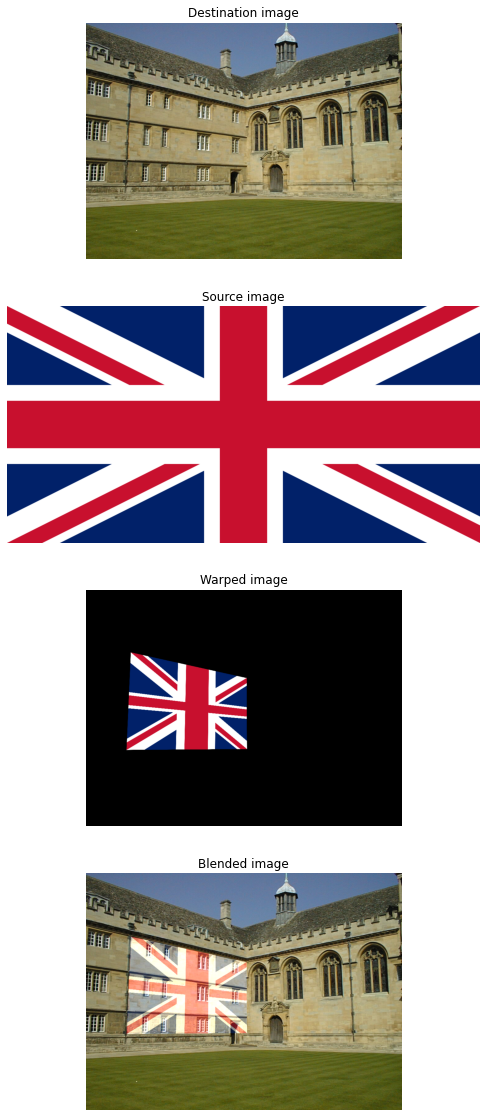

In [3]:
out1 = Homography('001.jpg','flag_uk.png',1,0.5)

[]


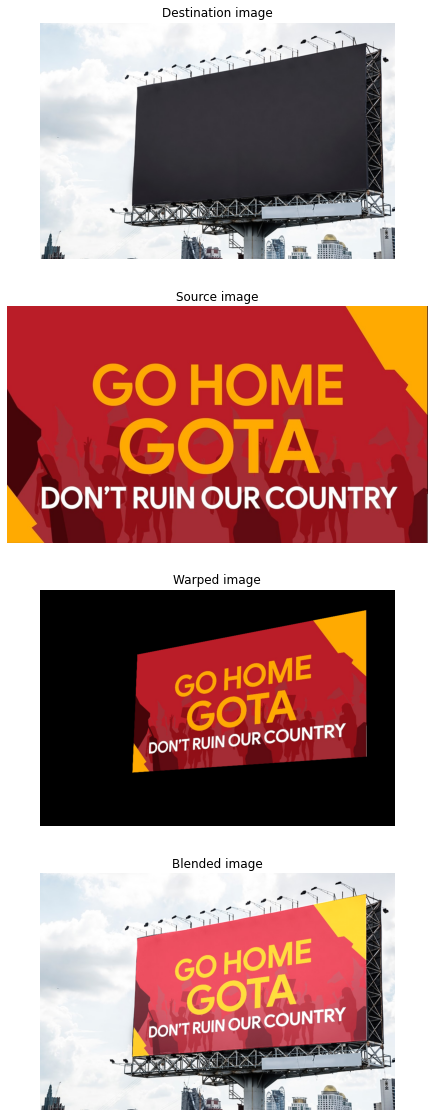

In [4]:
out2 = Homography('billboard_black.jpg','gotagohome.jpg',1,1)

[]


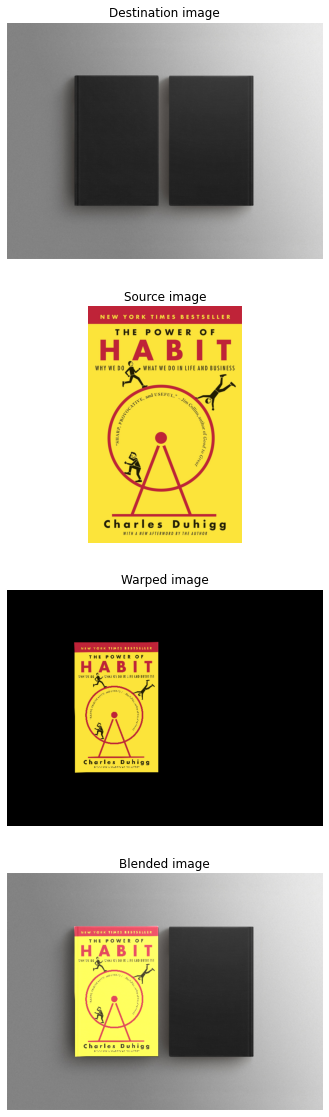

[]


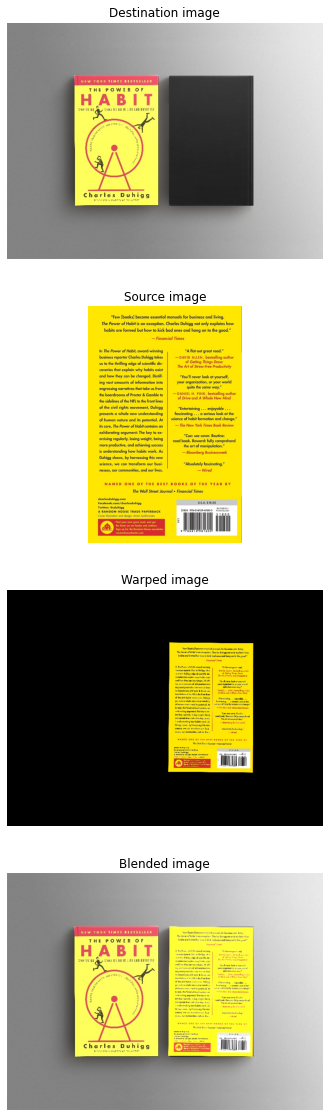

In [5]:
#Applying homography on the output of first homography

out3 = Homography(Homography('book.jpg','book_Front.jpg',1,1),'book_back.jpg',1,1)

#### Question 03

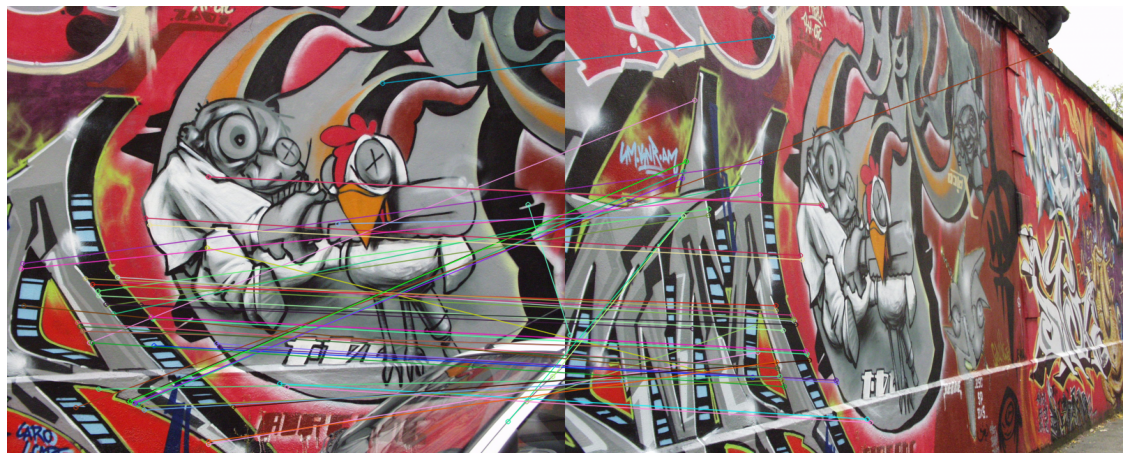

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread('graf\img1.ppm')
img1_rgb = cv.cvtColor(img1,cv.COLOR_BGR2RGB)

img5 = cv.imread('graf\img5.ppm')
img5_rgb = cv.cvtColor(img5,cv.COLOR_BGR2RGB)

assert img1 is not None
assert img5 is not None

#Feature detection from the image
sift = cv.SIFT_create(nOctaveLayers=3,contrastThreshold=0.1,edgeThreshold=25,sigma=1)
keypoints_1, descriptors_1 = sift.detectAndCompute(img1_rgb,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img5_rgb,None)

#Draw the detected keypoints
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

matched_img = cv.drawMatches(img1_rgb, keypoints_1, img5_rgb, keypoints_2, matches[:50], img5, flags=2)
plt.figure(figsize=(20,18))
plt.imshow(matched_img)
plt.axis('off')
plt.show()

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random

#Generate the correspoding points
def sift_matches(img1,img2):
    sift = cv.SIFT_create(nOctaveLayers=3,contrastThreshold=0.1,edgeThreshold=25,sigma=1)
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
         
    img1_points, img2_points = [], []

    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx

        x1, y1 = keypoints_1[img1_idx].pt
        x2, y2 = keypoints_2[img2_idx].pt

        img1_points.append((int(x1+0.5),int(y1+0.5)))
        img2_points.append((int(x2+0.5),int(y2+0.5)))

    return img1_points, img2_points

def homography_RANSAC(img1, img2):
    N = 10000
    t = 1
    max_inlier_count = 0

    img1_list, img2_list = sift_matches(img1,img2)
    img1_list, img2_list = np.array(img1_list), np.array(img2_list)
    
    for i in range(N):
        idx1 = random.randrange(0,len(img1_list))
        idx2 = random.randrange(0,len(img1_list))
        idx3 = random.randrange(0,len(img1_list))
        idx4 = random.randrange(0,len(img1_list))

        src_pt1, dst_pt1 = img1_list[idx1], img2_list[idx1]
        src_pt2, dst_pt2 = img1_list[idx2], img2_list[idx2]
        src_pt3, dst_pt3 = img1_list[idx3], img2_list[idx3]
        src_pt4, dst_pt4 = img1_list[idx4], img2_list[idx4]

        not_colinear =  bool(np.cross(src_pt1,src_pt2)) and bool(np.cross(src_pt1,src_pt3)) and bool(np.cross(src_pt1,src_pt4)) and bool(np.cross(src_pt2,src_pt3)) and bool(np.cross(src_pt2,src_pt4)) and bool(np.cross(src_pt3,src_pt4))
        if (not not_colinear): continue

        A = np.array([[src_pt1[0], src_pt1[1], 1, 0, 0, 0, (-dst_pt1[0]*src_pt1[0]), (-dst_pt1[0]*src_pt1[1]), -dst_pt1[0]],
                      [0, 0, 0, src_pt1[0], src_pt1[1], 1, (-dst_pt1[1]*src_pt1[0]), (-dst_pt1[1],src_pt1[1]), -dst_pt1[1]],
                     
                      [src_pt2[0], src_pt2[1], 1, 0, 0, 0, (-dst_pt2[0]*src_pt2[0]), (-dst_pt2[0]*src_pt2[1]), -dst_pt2[0]],
                      [0, 0, 0, src_pt2[0], src_pt2[1], 1, (-dst_pt2[1]*src_pt2[0]), (-dst_pt2[1],src_pt2[1]), -dst_pt2[1]],
                     
                      [src_pt3[0], src_pt3[1], 1, 0, 0, 0, (-dst_pt3[0]*src_pt3[0]), (-dst_pt3[0]*src_pt3[1]), -dst_pt3[0]],
                      [0, 0, 0, src_pt3[0], src_pt3[1], 1, (-dst_pt3[1]*src_pt3[0]), (-dst_pt3[1],src_pt3[1]), -dst_pt3[1]],
                     
                      [src_pt4[0], src_pt4[1], 1, 0, 0, 0, (-dst_pt4[0]*src_pt4[0]), (-dst_pt4[0]*src_pt1[1]), -dst_pt4[0]],
                      [0, 0, 0, src_pt4[0], src_pt4[1], 1, (-dst_pt4[1]*src_pt4[0]), (-dst_pt4[1],src_pt4[1]), -dst_pt4[1]],
                     
                      [0, 0, 0, 0, 0, 0, 0, 0, 1]])

        h = np.linalg.inv(A) @ np.array([[0,0,0,0,0,0,0,0,1]]).T
        h.reshape(3,3)
        X = np.vstack([img1_list.T , np.ones((1,len(img1_list)))])

        keys_transformed = h @ X

        z = np.array(keys_transformed[-1]).T
        keys_transformed = (keys_transformed[:2].T)/z

        inlier_count = 0
        for i in range(len(keys_transformed)):
            distance = np.sqrt( (keys_transformed[i][0]-img2_list[i][0])**2 + (keys_transformed[i][1]-img2_list[i][1])**2)
            if distance < t:
                inlier_count += 1

        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            H_RANSAC = h

    return H_RANSAC        


In [ ]:
H_RANSAC = homography_RANSAC(img1,img5)
print(H_RANSAC)

In [40]:
file = open('graf\H1to5p','r')
assert file is not None

H_dataset = np.array(file.read())
print(H_dataset)

   6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



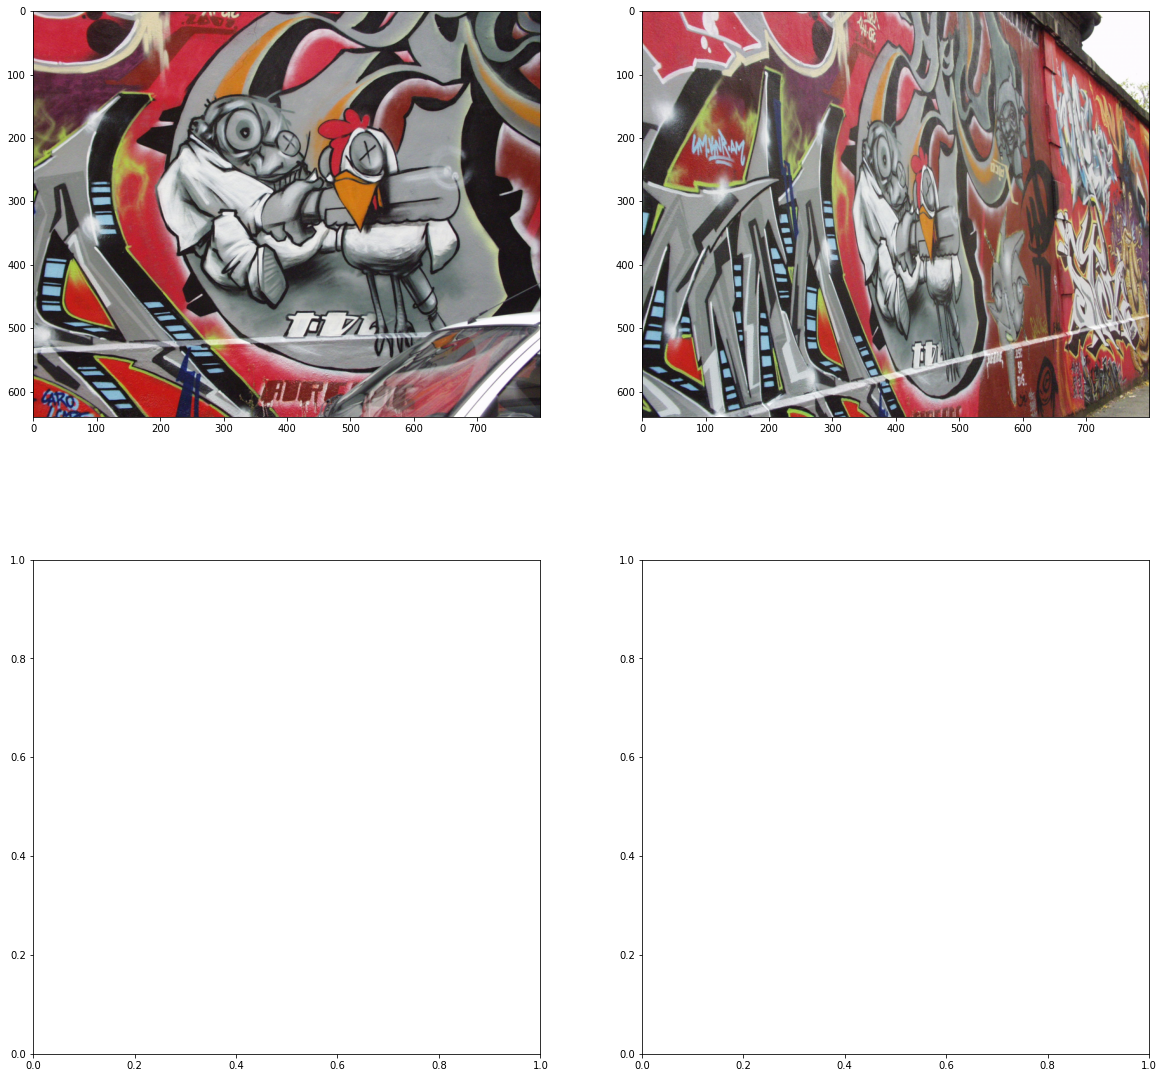

In [29]:
fig, ax = plt.subplots(2,2,figsize=(20,20))

ax[0][0].imshow(img1_rgb)

ax[0][1].imshow(img5_rgb)



plt.show()